# Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

### Llamado a funciones de preprocesamiento

In [3]:
df = preprocessing.remove_irrelevant_features(df)
df = preprocessing.missings_treatment(df)
df = preprocessing.one_hot_encodding(df)

### Separacion de datos de entrenamiento para los tres modelos a estudiar

In [4]:
# modelo 1
X_train, X_val, y_train, y_val = preprocessing.dataset_split(df)
# # modelo 2 y 3
# X_train_g = X_train[['ganancia_perdida_declarada_bolsa_argentina']]
# X_val_g = X_val[['ganancia_perdida_declarada_bolsa_argentina']]

# # modelo 3
# X_train_m = X_train.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')
# X_val_m = X_val.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

## Modelos

### Modelo 1
- se tratan todos los features como continuos

In [5]:
gnb = GaussianNB().fit(X_train, y_train)

y_pred = gnb.predict(X_val)
print(f"{np.sum(y_pred == y_val)} de {len(X_val)} predicciones correctas")

7598 de 9769 predicciones correctas


### Modelo 2
- se tratan todos los features como discretos 
- se descarta el feature ganancia_perdida_declarada_bolsa_argentina ya que toma demasiados valores y ademas tiene valores negativos que no son validos para el algoritmo

In [6]:
X_train_m = X_train.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')
X_val_m = X_val.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

mnb = MultinomialNB().fit(X_train_m, y_train)

y_pred = mnb.predict(X_val_m)

print(f"{np.sum(y_pred == y_val)} de {len(X_val_m)} predicciones correctas")

7366 de 9769 predicciones correctas


### Modelo 3
- se usa una combinación de naive bayes multinomial y gaussiano

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Modelo3(BaseEstimator, ClassifierMixin):
    def __init__(self, var_smoothing=1e-09, alpha=1): 
        self.var_smoothing = var_smoothing 
        self.alpha = alpha
        
    def fit(self, X_train, y_train):

        self._gnb = GaussianNB(var_smoothing = self.var_smoothing)
        self._mnb = MultinomialNB(alpha=self.alpha)
        
        X_train_g = X_train[['ganancia_perdida_declarada_bolsa_argentina']]
        X_train_m = X_train.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

        self._gnb.fit(X_train_g, y_train)
        self._mnb.fit(X_train_m, y_train)

        X_train_proba_g = pd.DataFrame(self._gnb.predict_proba(X_train_g)).drop(0, axis='columns')
        X_train_proba_m = pd.DataFrame(self._mnb.predict_proba(X_train_m)).drop(0, axis='columns')

        # se construye el dataframe de probabilidades con los datos de entrenamiento
        X_train_proba = pd.DataFrame()
        X_train_proba['1_gaussian'] = X_train_proba_g[1]
        X_train_proba['1_multinomial'] = X_train_proba_m[1]

        # se aplica naive bayes gaussiano al dataframe de probabilidades
        self._gnb_proba = GaussianNB().fit(X_train_proba, y_train)
        return self

    def predict(self, X_pred):
        X_pred_proba = self._construir_instancias_de_probabilidades(X_pred)
        return self._gnb_proba.predict(X_pred_proba)
    
    def predict_proba(self, X_pred):
        X_pred_proba = self._construir_instancias_de_probabilidades(X_pred)
        return self._gnb_proba.predict_proba(X_pred_proba)

    def _construir_instancias_de_probabilidades(self, X_pred):
        X_pred_g = X_pred[['ganancia_perdida_declarada_bolsa_argentina']]
        X_pred_m = X_pred.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

        # se aplica el modelo compuesto a los datos de validación y se obtiene la predicción
        X_pred_proba_g = pd.DataFrame(self._gnb.predict_proba(X_pred_g)).drop(0, axis='columns')
        X_pred_proba_m = pd.DataFrame(self._mnb.predict_proba(X_pred_m)).drop(0, axis='columns')
        X_pred_proba = pd.DataFrame()
        X_pred_proba['1_gaussian'] = X_pred_proba_g[1]
        X_pred_proba['1_multinomial'] = X_pred_proba_m[1]
        return X_pred_proba
    
#     def get_params(self, deep = False):
#         return {'var_smoothing': self.var_smoothing, 'alpha': self.alpha} 
    
#     def set_params(self, **parameters):
#         self.var_smoothing = parameters['var_smoothing']
#         self.alpha = parameters['alpha']
#         return self
        
modelo3 = Modelo3()
modelo3.fit(X_train, y_train)
y_pred = modelo3.predict(X_val)
print(f"{np.sum(y_pred == y_val)} de {len(X_val)} predicciones correctas")

7744 de 9769 predicciones correctas


In [8]:
import sklearn.metrics as metrics
metrics.accuracy_score(y_val, y_pred)

0.7927116388576108

In [9]:
metrics.precision_score(y_val, y_pred)

0.7212449255751014

In [10]:
metrics.recall_score(y_val, y_pred, pos_label = 0)

0.972225967372253

In [11]:
metrics.f1_score(y_val, y_pred)

0.3448722096408929

In [12]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      7417
           1       0.72      0.23      0.34      2352

    accuracy                           0.79      9769
   macro avg       0.76      0.60      0.61      9769
weighted avg       0.78      0.79      0.75      9769



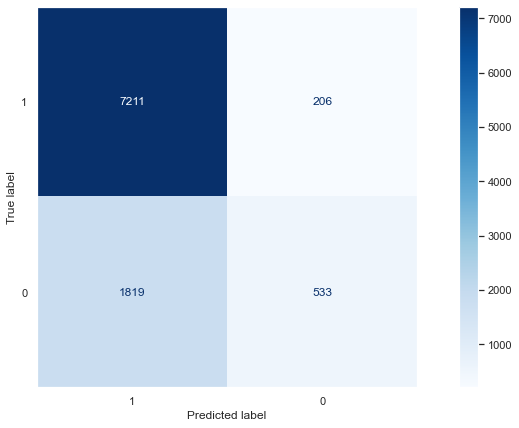

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
metrics.plot_confusion_matrix(modelo3._gnb_proba, modelo3._construir_instancias_de_probabilidades(X_val), y_val, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

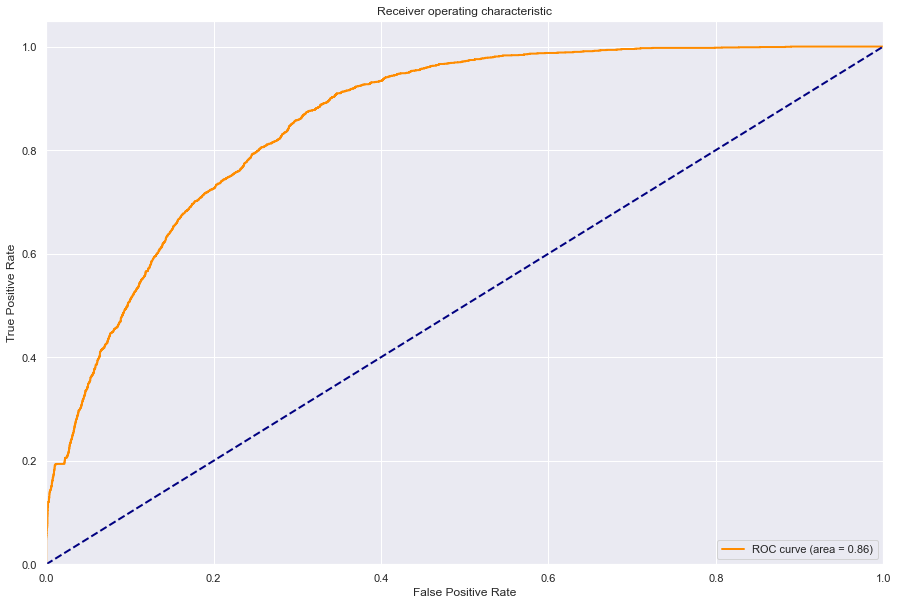

ROC AUC SCORE: 0.8585974466637133


In [14]:
def plot_roc(fpr, tpr, x):

    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
fpr, tpr, thresholds = metrics.roc_curve(y_val, modelo3.predict_proba(X_val)[:,1]) # aca le paso las probabilidades en vez de y_pred, es lo mas recomendado
plot_roc(fpr, tpr, thresholds)
print(f"ROC AUC SCORE: {metrics.roc_auc_score(y_val, modelo3.predict_proba(X_val)[:,1])}") # igual no hace falta esto porque se ve en el grafico (abajo a la derecha)

In [15]:
# se usa stratified kfold con los datos de entrenamiento para evaluar el modelo
from sklearn.model_selection import KFold, StratifiedKFold

def auc_roc_metric(modelo, X_train, y_train, n_splits = 5, imprimir_resultados = False):

    kf = StratifiedKFold(n_splits=5)
    auc_scores = []
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train.values, y_train.values)):

        modelo.fit(X_train.loc[train_index], y_train.loc[train_index])

        auc_score = metrics.roc_auc_score(y_train.loc[test_index], modelo.predict_proba(X_train.loc[test_index])[:,1])
        auc_scores.append(auc_score)

    if (imprimir_resultados): 
        i = 0
        for auc_score in auc_scores:
            print(f"    fold {i}: {auc_score:.4f}")
            i += 1
        print(f"ROC AUC SCORE media: {np.mean(auc_scores):.4f}")
    
    return np.mean(auc_scores)
auc_roc_metric(Modelo3(), X_train, y_train)

0.8592075018444382

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

smoothing = np.array([1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05,1e-04, 1e-03, 1e-02, 1e-01, 1])

params = {'var_smoothing': smoothing, 'alpha': smoothing}
# params = {'var_smoothing': smoothing}

estimador = Modelo3()
# estimador = gnb

# gscv = GridSearchCV(estimador, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True).fit(X_train, y_train)
gscv = RandomizedSearchCV(estimador, params,n_iter=60 , scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True).fit(X_train, y_train)

In [17]:
print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
gscv.best_estimator_

Best score: 0.8654084458173041
Best params {'var_smoothing': 1.0, 'alpha': 0.1}


Modelo3(alpha=0.1, var_smoothing=1.0)

In [19]:
auc_roc_metric(Modelo3(var_smoothing = 1.0, alpha = 0.1), X_train, y_train, imprimir_resultados= True)

    fold 0: 0.8635
    fold 1: 0.8673
    fold 2: 0.8725
    fold 3: 0.8634
    fold 4: 0.8603
ROC AUC SCORE media: 0.8654


0.8654084458173041

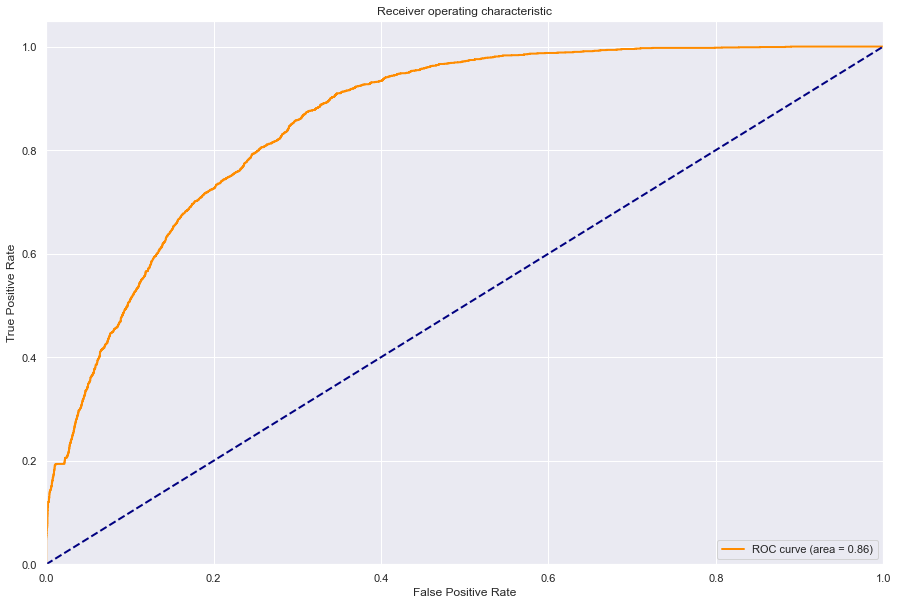

In [21]:
m = Modelo3(var_smoothing = 1.0, alpha = 0.1)
m.fit(X_train, y_train)

fpr, tpr, thresholds = metrics.roc_curve(y_val, modelo3.predict_proba(X_val)[:,1])
plot_roc(fpr, tpr, thresholds)